<a href="https://colab.research.google.com/github/naomiehl/ComputerVision_CleanDirty/blob/main/Naomie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import scipy.stats as stats
import torch
import torch.nn as nn
import torch.optim as optim
#from scipy.stats import qmc
from scipy import optimize
import random
from scipy.integrate import quad
from scipy.optimize import minimize
from scipy.interpolate import interp1d
#from py_vollib.black_scholes.implied_volatility import implied_volatility as implVola
import matplotlib.pyplot as plt

In [2]:
# European Options

def EuropeanCall(S, K, T, r, sigma):
    if(T == 0.0):
        T = np.finfo(np.float64).eps
    d1 = (np.log(S/K)+(r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    d2 = d1-sigma*np.sqrt(T)
    return S*norm.cdf(d1)-norm.cdf(d2)*K*np.exp(-r*T)

def EuropeanPut(S, K, T, r, sigma):
    if(T == 0.0):
        T = np.finfo(np.float64).eps
        # return np.maximum(K - S, 0)
    d1 = (np.log(S/K)+(r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    d2 = d1-sigma*np.sqrt(T)
    return -S*norm.cdf(-d1)+norm.cdf(-d2)*K*np.exp(-r*T)

def EuropeanOption(S, K, T, r, sigma, cp):
    if(cp == "c"):
        return EuropeanCall(S, K, T, r, sigma)
    elif(cp == "p"):
        return EuropeanPut(S, K, T, r, sigma)

def EuropeanCallDelta(S, K, T, r, sigma):
    if(T == 0.0):
        T = np.finfo(np.float64).eps
        # return np.heaviside(S-K, 0)
    d1 = (np.log(S/K)+(r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    return norm.cdf(d1)

def EuropeanPutDelta(S, K, T, r, sigma):
    if(T == 0.0):
        T = np.finfo(np.float64).eps
        # return -np.heaviside(K-S, 0)
    d1 = (np.log(S/K)+(r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    return -norm.cdf(-d1)

def EuropeanDelta(S, K, T, r, sigma, cp):
    if(cp == "c"):
        return EuropeanCallDelta(S, K, T, r, sigma)
    elif(cp == "p"):
        return EuropeanPutDelta(S, K, T, r, sigma)

def EuropeanGamma(S, K, T, r, sigma):
    d1 = (np.log(S/K)+(r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    return norm.pdf(d1)/(S*sigma*sqrt(T))

def EuropeanVega(S, K, T, r, sigma):
    d1 = (np.log(S/K)+(r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    return S*np.sqrt(T)*norm.pdf(d1)

## 1/ Context : Market Maker buy 1 eth with a maturity of 30 days, without any hedgning 

In [3]:
r = 0.02
sigma = 0.2
vol = 0.2
T = 0.1
S = 20000
K = 20000

EuropeanCall(S, K, T, r, sigma)

524.2703018156171

In [4]:
def hedgingStrategy(S, K, T, r, sigma, cp, n, m):
    timeGrid = np.linspace(0, T, n)
    dt = T/(n-1)

    trajectory = np.zeros((n, m))
    bank = np.zeros((n, m))
    strategy = np.zeros((n, m))
    deltaBS = np.zeros((n, m))
    value = np.zeros((n, m))
    profit = np.zeros((n, m))

    timeToMaturity = T
    trajectory[0] = S
    valueBS = EuropeanOption(trajectory[0], K, timeToMaturity, r, sigma, cp)
    strategy[0] = deltaBS[0]*S
    value[0] = valueBS
    deltaBS[0] = EuropeanDelta(trajectory[0], K, timeToMaturity, r, sigma, cp)
    bank[0] = valueBS - strategy[0]
    profit[0] = value[0] - valueBS
    for i in np.arange(1, len(timeGrid)):
        r = random.uniform(0, 1)
        sigma = random.uniform(0, 1)
        vol = random.uniform(0, 1)
        timeToMaturity = T - timeGrid[i]
        noise = np.random.normal(0, 1, m)

        trajectory[i] = trajectory[i-1]*np.exp((r-0.5*vol**2)*dt + vol*np.sqrt(dt)*noise)
        valueBS = EuropeanOption(trajectory[i], K, timeToMaturity, r, sigma, cp)
        deltaBS[i] = EuropeanDelta(trajectory[i], K, timeToMaturity, r, sigma, cp)
        strategy[i] = deltaBS[i]*trajectory[i]
        value[i] = deltaBS[i-1]*trajectory[i] + np.exp(r*dt)*bank[i-1]
        bank[i] = value[i] - strategy[i]
        profit[i] = value[i] - valueBS

    return timeGrid, trajectory, bank, strategy, deltaBS, profit

In [5]:
nbSteps = 300
nbSim = 1000

timeGrid, trajectory, bank, strategy, deltaBS, profit = hedgingStrategy(S, K, T, r, sigma, "c", nbSteps, nbSim)


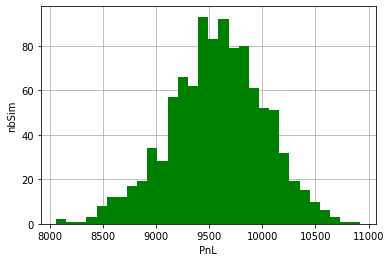

In [6]:
plt.hist(profit[-1], 30, facecolor='g', zorder=20)
plt.xlabel("PnL")
plt.ylabel("nbSim")
plt.grid(zorder=20)
plt.show()

In [7]:
def entropic_loss(pnl):
    pnl = torch.tensor(pnl)
    return -torch.mean(-torch.exp(-pnl)).numpy()
    
def evaluate_model(Y):
    Y = pd.Series(Y)

    metric = {
        "Entropic Loss Measure (ERM)" : entropic_loss(Y),
        "Mean" : Y.mean(),
        "Std" : Y.std(),
        "VaR99" : Y.quantile(0.01),
        "VaR95" : Y.quantile(0.05),
        "VaR90" : Y.quantile(0.1),
        "VaR80" : Y.quantile(0.2),
        "VaR50" : Y.quantile(0.5)
    }
    return metric

In [8]:
evaluate_model(profit[-1])

{'Entropic Loss Measure (ERM)': -0.0,
 'Mean': 9574.17231358211,
 'Std': 445.5504117202772,
 'VaR50': 9587.410182612617,
 'VaR80': 9215.922460183267,
 'VaR90': 8995.279082751362,
 'VaR95': 8812.359510468714,
 'VaR99': 8490.367418949378}

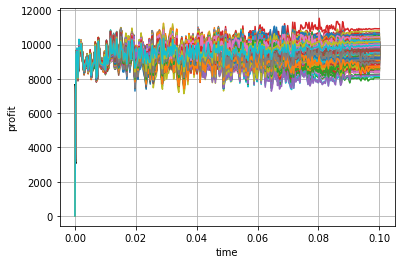

In [9]:
plt.plot(timeGrid, profit, zorder=100)
plt.xlabel("time")
plt.ylabel("profit")
plt.grid(zorder=20)
plt.show()

## 2/ Context : Market Maker buy 1 eth with a maturity of 30 days, without hedgning static

In [10]:
def hedgingStrategy(S, K, T, r, sigma, cp, n, m):
    timeGrid = np.linspace(0, T, n)
    dt = T/(n-1)

    trajectory = np.zeros((n, m))
    bank = np.zeros((n, m))
    strategy = np.zeros((n, m))
    deltaBS = np.zeros((n, m))
    value = np.zeros((n, m))
    profit = np.zeros((n, m))

    timeToMaturity = T
    trajectory[0] = S
    valueBS = EuropeanOption(trajectory[0], K, timeToMaturity, r, sigma, cp)
    deltaBS[0] = EuropeanDelta(trajectory[0], K, timeToMaturity, r, sigma, cp)
    strategy[0] = deltaBS[0]*S
    value[0] = valueBS
    bank[0] = valueBS - strategy[0]
    profit[0] = value[0] - valueBS
    for i in np.arange(1, len(timeGrid)):
        r = random.uniform(0, 1)
        vol = random.uniform(0, 1)
        sigma = random.uniform(0, 1)
        timeToMaturity = T - timeGrid[i]
        noise = np.random.normal(0, 1, m)
        #noise = noiseSobol[...,i-1]
        trajectory[i] = trajectory[i-1]*np.exp((r-0.5*vol**2)*dt + vol*np.sqrt(dt)*noise)
        valueBS = EuropeanOption(trajectory[i], K, timeToMaturity, r, sigma, cp)
        deltaBS[i] = EuropeanDelta(trajectory[i], K, timeToMaturity, r, sigma, cp)
        strategy[i] = deltaBS[i]*trajectory[i]
        value[i] = deltaBS[i-1]*trajectory[i] + np.exp(r*dt)*bank[i-1]
        bank[i] = value[i] - strategy[i]
        profit[i] = value[i] - valueBS

    return timeGrid, trajectory, bank, strategy, deltaBS, profit

In [11]:
nbSteps = 300
nbSim = 1000

timeGrid, trajectory, bank, strategy, deltaBS, profit = hedgingStrategy(S, K, T, r, sigma, "c", nbSteps, nbSim)
print(np.mean(profit[-1]))
print(np.std(profit[-1]))

-1460.649097294739
401.9001447611769


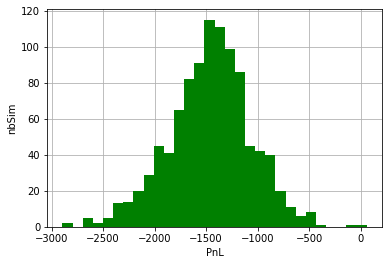

In [12]:
plt.hist(profit[-1], 30, facecolor='g', zorder=20)
plt.xlabel("PnL")
plt.ylabel("nbSim")
plt.grid(zorder=20)
plt.show()

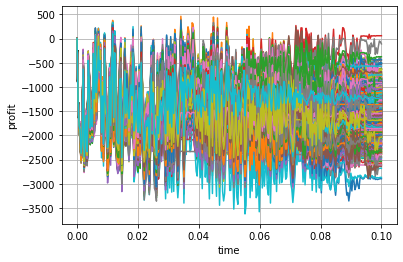

In [13]:
plt.plot(timeGrid, profit, zorder=100)
plt.xlabel("time")
plt.ylabel("profit")
plt.grid(zorder=20)
plt.show()

In [14]:
evaluate_model(profit[-1])

{'Entropic Loss Measure (ERM)': inf,
 'Mean': -1460.649097294739,
 'Std': 402.10124567181555,
 'VaR50': -1438.8477263281347,
 'VaR80': -1784.5669141597775,
 'VaR90': -1988.2540424070967,
 'VaR95': -2171.7521943995143,
 'VaR99': -2472.7438088453173}

## 3/ Context : Market Maker buy 1 eth with a maturity of 30 days, with a delta hedge dynamic 

In [15]:
def hedgingStrategy(S, K, T, r, sigma, cp, n, m):
    timeGrid = np.linspace(0, T, n)
    dt = T/(n-1)

    trajectory = np.zeros((n, m))
    bank = np.zeros((n, m))
    strategy = np.zeros((n, m))
    deltaBS = np.zeros((n, m))
    value = np.zeros((n, m))
    profit = np.zeros((n, m))

    timeToMaturity = T
    trajectory[0] = S
    valueBS = EuropeanOption(trajectory[0], K, timeToMaturity, r, sigma, cp)
    deltaBS[0] = EuropeanDelta(trajectory[0], K, timeToMaturity, r, sigma, cp)
    strategy[0] = deltaBS[0]*S
    value[0] = valueBS
    bank[0] = valueBS - strategy[0]
    profit[0] = value[0] - valueBS
    for i in np.arange(1, len(timeGrid)):
        r = random.uniform(0, 1)
        sigma = random.uniform(0, 1)
        vol = random.uniform(0, 1)
        timeToMaturity = T - timeGrid[i]
        noise = np.random.normal(0, 1, m)
        #noise = noiseSobol[...,i-1]
        trajectory[i] = trajectory[i-1]*np.exp((r-0.5*vol**2)*dt + vol*np.sqrt(dt)*noise)
        valueBS = EuropeanOption(trajectory[i], K, timeToMaturity, r, sigma, cp)
        deltaBS[i] = EuropeanDelta(trajectory[i], K, timeToMaturity, r, sigma, cp)
        strategy[i] = deltaBS[i] * trajectory[i]
        value[i] = deltaBS[i-1]*trajectory[i] + np.exp(r*dt)*bank[i-1]
        bank[i] = value[i] - strategy[i]
        profit[i] = value[i] - valueBS

    return timeGrid, trajectory, bank, strategy, deltaBS, profit

In [16]:
nbSteps = 300
nbSim = 1000

timeGrid, trajectory, bank, strategy, deltaBS, profit = hedgingStrategy(S, K, T, r, sigma, "c", nbSteps, nbSim)
print(np.mean(profit[-1]))
print(np.std(profit[-1]))

-1463.2381872175042
429.49858367996154


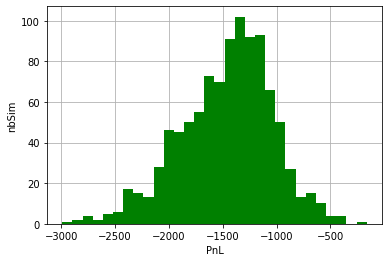

In [17]:
plt.hist(profit[-1], 30, facecolor='g', zorder=20)
plt.xlabel("PnL")
plt.ylabel("nbSim")
plt.grid(zorder=20)
plt.show()

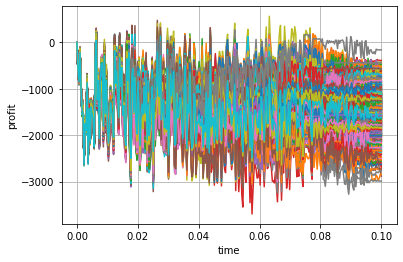

In [18]:
plt.plot(timeGrid, profit, zorder=100)
plt.xlabel("time")
plt.ylabel("profit")
plt.grid(zorder=20)
plt.show()

In [19]:
evaluate_model(profit[-1])

{'Entropic Loss Measure (ERM)': inf,
 'Mean': -1463.2381872175042,
 'Std': 429.7134941681063,
 'VaR50': -1410.9900874464038,
 'VaR80': -1815.578572707462,
 'VaR90': -2023.4996513119906,
 'VaR95': -2245.539656742657,
 'VaR99': -2558.237820291174}

## Context : Market Maker buy 1 eth with a maturity of 30 days, with a delta hedge dynamic and transaction cost

In [20]:
TC= 0.003

In [21]:
def hedgingStrategy(S, K, T, r, sigma, cp, n, m):
    timeGrid = np.linspace(0, T, n)
    dt = T/(n-1)

    trajectory = np.zeros((n, m))
    bank = np.zeros((n, m))
    strategy = np.zeros((n, m))
    deltaBS = np.zeros((n, m))
    value = np.zeros((n, m))
    profit = np.zeros((n, m))

    timeToMaturity = T
    trajectory[0] = S
    valueBS = EuropeanOption(trajectory[0], K, timeToMaturity, r, sigma, cp)
    deltaBS[0] = EuropeanDelta(trajectory[0], K, timeToMaturity, r, sigma, cp)
    strategy[0] = deltaBS[0]*S
    value[0] = valueBS
    bank[0] = valueBS - strategy[0] - TC*trajectory[0]*np.abs(deltaBS[0]) # cout de transactions
    profit[0] = value[0] - valueBS
    for i in np.arange(1, len(timeGrid)):
        timeToMaturity = T - timeGrid[i]
        noise = np.random.normal(0, 1, m)
        trajectory[i] = trajectory[i-1]*np.exp((r-0.5*vol**2)*dt + vol*np.sqrt(dt)*noise)
        valueBS = EuropeanOption(trajectory[i], K, timeToMaturity, r, sigma, cp)
        deltaBS[i] = EuropeanDelta(trajectory[i], K, timeToMaturity, r, sigma, cp)
        strategy[i] = deltaBS[i]*trajectory[i]
        value[i] = deltaBS[i-1]*trajectory[i] + np.exp(r*dt)*bank[i-1]
        bank[i] = value[i] - strategy[i] - TC*trajectory[i]*np.abs(deltaBS[i] - deltaBS[i-1])
        profit[i] = value[i] - valueBS

    return timeGrid, trajectory, bank, strategy, deltaBS, profit

In [22]:
nbSim = 1000
nbSteps = 30

timeGrid, trajectory, bank, strategy, deltaBS, profit = hedgingStrategy(S, K, T, r, sigma, "c", nbSteps, nbSim)
print('mean=', np.mean(profit[-1]))
print('std=', np.std(profit[-1]))

mean= -126.97894894460832
std= 89.90716573187444


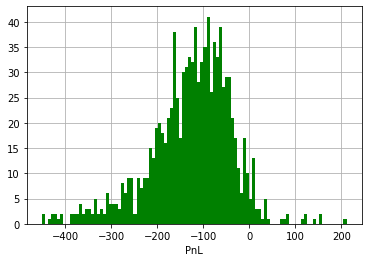

In [23]:
plt.hist(profit[-1],100, facecolor='g', zorder=5)
plt.xlabel("PnL")
plt.grid(zorder=5)
plt.show()

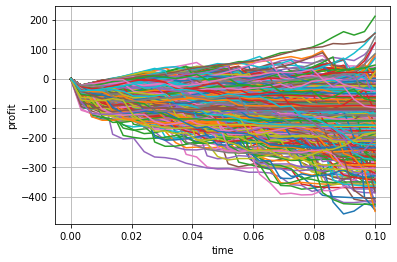

In [24]:
plt.plot(timeGrid, profit, zorder=100)
plt.xlabel("time")
plt.ylabel("profit")
plt.grid(zorder=20)
plt.show()

In [25]:
nbSim = 1000
nbSteps = 300

timeGrid, trajectory, bank, strategy, deltaBS, profit = hedgingStrategy(S, K, T, r, sigma, "c", nbSteps, nbSim)
print('mean=', np.mean(profit[-1]))
print('std=', np.std(profit[-1]))

mean= -362.19820844090896
std= 129.52065081155396


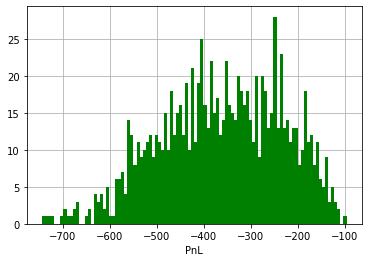

In [26]:
plt.hist(profit[-1],100, facecolor='g', zorder=5)
plt.xlabel("PnL")
plt.grid(zorder=5)
plt.show()

In [27]:
mean_pnl = []
std_pnl = []
for i in range(30,500):
    timeGrid, trajectory, bank, strategy, deltaBS, profit = hedgingStrategy(S, K, T, r, sigma, "c", i, nbSim)
    mean_pnl.append(np.mean(profit[-1]))
    std_pnl.append(np.std(profit[-1])) 

In [28]:
step = []
for i in range(30,500):
    step.append(i)

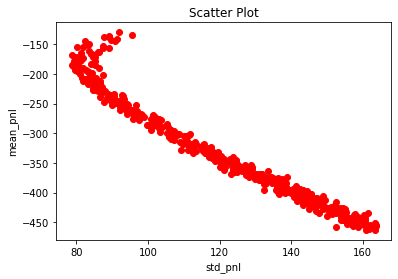

In [29]:
plt.scatter(std_pnl, mean_pnl, color='r')
plt.title('Scatter Plot')
plt.xlabel('std_pnl')
plt.ylabel('mean_pnl')
plt.show()

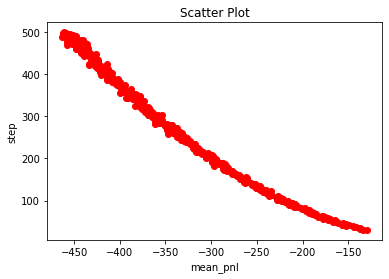

In [30]:
plt.scatter(mean_pnl, step, color='r')
plt.title('Scatter Plot')
plt.xlabel('mean_pnl')
plt.ylabel('step')
plt.show()

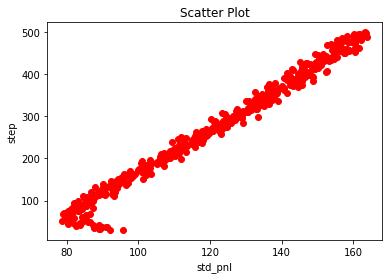

In [31]:
plt.scatter(std_pnl, step, color='r')
plt.title('Scatter Plot')
plt.xlabel('std_pnl')
plt.ylabel('step')
plt.show()

## Context : Market Maker buy 1 eth with a maturity of 30 days, with a delta hedge dynamic and transaction cost and threshold

In [32]:
def hedgingStrategy(S, K, T, r, sigma, cp, n, m,threshold):
    timeGrid = np.linspace(0, T, n)
    dt = T/(n-1)

    trajectory = np.zeros((n, m))
    bank = np.zeros((n, m))
    strategy = np.zeros((n, m))
    deltaBS = np.zeros((n, m))
    value = np.zeros((n, m))
    profit = np.zeros((n, m))

    timeToMaturity = T
    trajectory[0] = S
    valueBS = EuropeanOption(trajectory[0], K, timeToMaturity, r, sigma, cp)
    deltaBS[0] = EuropeanDelta(trajectory[0], K, timeToMaturity, r, sigma, cp)
    strategy[0] = deltaBS[0]*S
    value[0] = valueBS
    bank[0] = valueBS - strategy[0]
    profit[0] = value[0] - valueBS
    for i in np.arange(1, len(timeGrid)):
        timeToMaturity = T - timeGrid[i]
        noise = np.random.normal(0, 1, m)
        trajectory[i] = trajectory[i-1]*np.exp((r-0.5*vol**2)*dt + vol*np.sqrt(dt)*noise)
        valueBS = EuropeanOption(trajectory[i], K, timeToMaturity, r, sigma, cp)
        currentDeltaBS = EuropeanDelta(trajectory[i], K, timeToMaturity, r, sigma, cp)
        mask = np.abs(currentDeltaBS - deltaBS[i-1])/deltaBS[i-1] > threshold
        #print(np.abs(currentDeltaBS - deltaBS[i-1])/deltaBS[i-1])
        maskInv = np.invert(mask)
        deltaBS[i][mask] = currentDeltaBS[mask]
        strategy[i][mask] = deltaBS[i][mask]*trajectory[i][mask]
        value[i][mask] = deltaBS[i-1][mask]*trajectory[i][mask] + np.exp(r*dt)*bank[i-1][mask]
        bank[i][mask] = value[i][mask] - strategy[i][mask] - TC*trajectory[i][mask]*np.abs(deltaBS[i][mask] - deltaBS[i-1][mask])
        profit[i][mask] = value[i][mask] - valueBS[mask]

        deltaBS[i][maskInv] = deltaBS[i-1][maskInv]
        strategy[i][maskInv] = deltaBS[i][maskInv]*trajectory[i][maskInv]
        value[i][maskInv] = deltaBS[i-1][maskInv]*trajectory[i][maskInv] + np.exp(r*dt)*bank[i-1][maskInv]
        bank[i][maskInv] = value[i][maskInv] - strategy[i][maskInv] - TC*trajectory[i][maskInv]*np.abs(deltaBS[i][maskInv] - deltaBS[i-1][maskInv])
        profit[i][maskInv] = value[i][maskInv] - valueBS[maskInv]

    return timeGrid, trajectory, bank, strategy, deltaBS, profit

In [33]:
nbSim = 1000
nbSteps = 300
threshold = 0.05
r=0

timeGrid, trajectory, bank, strategy, deltaBS, profit = hedgingStrategy(S, K, T, r, sigma, "c", nbSteps, nbSim, threshold)
print('mean=', np.mean(profit[-1]))
print('std=', np.std(profit[-1]))

mean= -251.06263455778088
std= 115.74571968954866


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


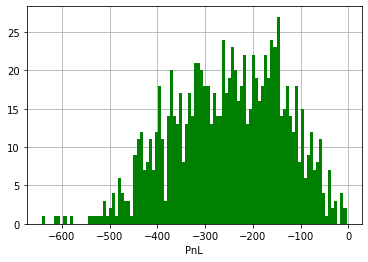

In [34]:
plt.hist(profit[-1],100, facecolor='g', zorder=5)
plt.xlabel("PnL")
plt.grid(zorder=5)
plt.show()

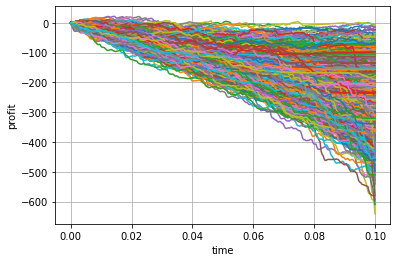

In [35]:
plt.plot(timeGrid, profit, zorder=100)
plt.xlabel("time")
plt.ylabel("profit")
plt.grid(zorder=20)
plt.show()

# 2/ With Historical Data

In [ ]:
from google.colab import files
uploaded = files.upload()
import io
eth = pd.read_csv(io.BytesIO(uploaded['ETH-USD.csv']))

In [ ]:
eth = eth[['Open']]
eths = []
for i in range(0,len(eth)-30):
    eths.append(eth[i:i+30])

In [ ]:
eth

In [ ]:
for i in range(0,len(eth)-30):
    #eths[i] = (eths[i]-eths[i].mean())/eths[i].std()
    eths[i] = (eths[i] * 3000)  / eths[i].iloc[0]

In [ ]:
trajectory = np.zeros((1568,29))
for i in range(0,len(eth)-30):
    for j in range(0,29):
        trajectory[i][j] = eths[i].iloc[j]

### 1/ Context : Market Maker buy 1 eth with a maturity of 30 days, without any hedgning 

In [ ]:
r = 0.04
sigma = 0.8
vol = 0.5

n = 30
m = 1560

T = 30/365
S = 3000
K = 3000


EuropeanCall(S, K, T, r, sigma)

In [ ]:
def hedgingStrategy(S, K, T, r, sigma, cp, n, m):
    timeGrid = np.linspace(0, T, n)
    dt = T/(n-1)

    bank = np.zeros((n, m))
    strategy = np.zeros((n, m))
    deltaBS = np.zeros((n, m))
    value = np.zeros((n, m))
    profit = np.zeros((n, m))

    timeToMaturity = T
    valueBS = EuropeanOption(S, K, timeToMaturity, r, sigma, cp)
    strategy[0] = deltaBS[0]*S
    value[0] = valueBS
    bank[0] = valueBS - strategy[0]
    profit[0] = value[0] - valueBS
    for i in np.arange(1, len(timeGrid)):
        timeToMaturity = T - timeGrid[i]
        noise = np.random.normal(0, 1, m)
    
        valueBS = EuropeanOption(trajectory.T[i], K, timeToMaturity, r, sigma, cp)
        strategy[i] = deltaBS[i]*trajectory.T[i]
        value[i] = deltaBS[i-1]*trajectory.T[i] + np.exp(r*dt)*bank[i-1]
        bank[i] = value[i] - strategy[i]
        profit[i] = value[i] - valueBS

    return timeGrid, trajectory, bank, strategy, deltaBS, profit

In [ ]:
nbSteps = 29
nbSim = 1568
timeGrid, trajectory, bank, strategy, deltaBS, profit = hedgingStrategy(S, K, T, r, sigma, "c", nbSteps, nbSim)
print(np.mean(profit[-1]))
print(np.std(profit[-1]))

In [ ]:
plt.hist(profit[-1], 30, facecolor='g', zorder=20)
plt.xlabel("PnL")
plt.ylabel("nbSim")
plt.grid(zorder=20)
plt.show()

In [ ]:
plt.plot(timeGrid, profit, zorder=100)
plt.xlabel("time")
plt.ylabel("profit")
plt.grid(zorder=20)
plt.show()

## 2/ Context: Market Maker buy 1 eth with a maturity of 30 days, with hedgning static

In [ ]:
def hedgingStrategy(S, K, T, r, sigma, cp, n, m):
    timeGrid = np.linspace(0, T, n)
    dt = T/(n-1)

    bank = np.zeros((n, m))
    strategy = np.zeros((n, m))
    deltaBS = np.zeros((n, m))
    value = np.zeros((n, m))
    profit = np.zeros((n, m))

    timeToMaturity = T
    valueBS = EuropeanOption(S, K, timeToMaturity, r, sigma, cp)
    deltaBS[0] = EuropeanDelta(trajectory.T[0], K, timeToMaturity, r, sigma, cp)
    strategy[0] = deltaBS[0]*S
    value[0] = valueBS
    bank[0] = valueBS - strategy[0]
    profit[0] = value[0] - valueBS
    for i in np.arange(1, len(timeGrid)):
        timeToMaturity = T - timeGrid[i]
        noise = np.random.normal(0, 1, m)
    
        valueBS = EuropeanOption(trajectory.T[i], K, timeToMaturity, r, sigma, cp)
        strategy[i] = deltaBS[i]*trajectory.T[i]
        value[i] = deltaBS[i-1]*trajectory.T[i] + np.exp(r*dt)*bank[i-1]
        bank[i] = value[i] - strategy[i]
        profit[i] = value[i] - valueBS

    return timeGrid, trajectory, bank, strategy, deltaBS, profit

In [ ]:
nbSteps = 29
nbSim = 1568

timeGrid, trajectory, bank, strategy, deltaBS, profit = hedgingStrategy(S, K, T, r, sigma, "c", nbSteps, nbSim)
print(np.mean(profit[-1]))
print(np.std(profit[-1]))

In [ ]:
plt.hist(profit[-1], 30, facecolor='g', zorder=20)
plt.xlabel("PnL")
plt.ylabel("nbSim")
plt.grid(zorder=20)
plt.show()

In [ ]:
plt.plot(timeGrid, profit, zorder=100)
plt.xlabel("time")
plt.ylabel("profit")
plt.grid(zorder=20)
plt.show()

## 3/ Context: Market Maker buy 1 eth with a maturity of 30 days, with hedgning dynamic

In [ ]:
def hedgingStrategy(S, K, T, r, sigma, cp, n, m):
    timeGrid = np.linspace(0, T, n)
    dt = T/(n-1)

    bank = np.zeros((n, m))
    strategy = np.zeros((n, m))
    deltaBS = np.zeros((n, m))
    value = np.zeros((n, m))
    profit = np.zeros((n, m))

    timeToMaturity = T
    valueBS = EuropeanOption(S, K, timeToMaturity, r, sigma, cp)
    deltaBS[0] = EuropeanDelta(trajectory.T[0], K, timeToMaturity, r, sigma, cp)
    strategy[0] = deltaBS[0]*S
    value[0] = valueBS
    bank[0] = valueBS - strategy[0]
    profit[0] = value[0] - valueBS
    for i in np.arange(1, len(timeGrid)):
        timeToMaturity = T - timeGrid[i]
        noise = np.random.normal(0, 1, m)
    
        valueBS = EuropeanOption(trajectory.T[i], K, timeToMaturity, r, sigma, cp)
        deltaBS[i] = EuropeanDelta(trajectory.T[i], K, timeToMaturity, r, sigma, cp)
        strategy[i] = deltaBS[i]*trajectory.T[i]
        value[i] = deltaBS[i-1]*trajectory.T[i] + np.exp(r*dt)*bank[i-1]
        bank[i] = value[i] - strategy[i]
        profit[i] = value[i] - valueBS

    return timeGrid, trajectory, bank, strategy, deltaBS, profit

In [ ]:
nbSteps = 29
nbSim = 1568

timeGrid, trajectory, bank, strategy, deltaBS, profit = hedgingStrategy(S, K, T, r, sigma, "c", nbSteps, nbSim)
print(np.mean(profit[-1]))
print(np.std(profit[-1]))

In [ ]:
plt.hist(profit[-1], 30, facecolor='g', zorder=20)
plt.xlabel("PnL")
plt.ylabel("nbSim")
plt.grid(zorder=20)
plt.show()

In [ ]:
plt.plot(timeGrid, profit, zorder=100)
plt.xlabel("time")
plt.ylabel("profit")
plt.grid(zorder=20)
plt.show()

## 4/ Context: delta hedge dynamic + transactions cost

In [ ]:
def hedgingStrategy(S, K, T, r, sigma, cp, n, m):
    timeGrid = np.linspace(0, T, n)
    dt = T/(n-1)

    bank = np.zeros((n, m))
    strategy = np.zeros((n, m))
    deltaBS = np.zeros((n, m))
    value = np.zeros((n, m))
    profit = np.zeros((n, m))

    timeToMaturity = T
    valueBS = EuropeanOption(S, K, timeToMaturity, r, sigma, cp)
    deltaBS[0] = EuropeanDelta(trajectory.T[0], K, timeToMaturity, r, sigma, cp)
    strategy[0] = deltaBS[0]*S
    value[0] = valueBS
    bank[0] = valueBS - strategy[0] - TC*trajectory.T[0]*np.abs(deltaBS[0]) # cout de transactions
    profit[0] = value[0] - valueBS
    for i in np.arange(1, len(timeGrid)):
        timeToMaturity = T - timeGrid[i]
        valueBS = EuropeanOption(trajectory.T[i], K, timeToMaturity, r, sigma, cp)
        deltaBS[i] = EuropeanDelta(trajectory.T[i], K, timeToMaturity, r, sigma, cp)
        strategy[i] = deltaBS[i]*trajectory.T[i]
        value[i] = deltaBS[i-1]*trajectory.T[i] + np.exp(r*dt)*bank[i-1]
        bank[i] = value[i] - strategy[i] - TC*trajectory.T[i]*np.abs(deltaBS[i] - deltaBS[i-1])
        profit[i] = value[i] - valueBS

    return timeGrid, trajectory, bank, strategy, deltaBS, profit

In [ ]:
TC = 0.003
nbSteps = 29
nbSim = 1568

timeGrid, trajectory, bank, strategy, deltaBS, profit = hedgingStrategy(S, K, T, r, sigma, "c", nbSteps, nbSim)
print(np.mean(profit[-1]))
print(np.std(profit[-1]))

In [ ]:
plt.hist(profit[-1], 30, facecolor='g', zorder=20)
plt.xlabel("PnL")
plt.ylabel("nbSim")
plt.grid(zorder=20)
plt.show()

In [ ]:
plt.plot(timeGrid, profit, zorder=100)
plt.xlabel("time")
plt.ylabel("profit")
plt.grid(zorder=20)
plt.show()

## 4/ Context : delta hedge dynamic + transaction cost + threshold

In [ ]:
def hedgingStrategy(S, K, T, r, sigma, cp, n, m):
    timeGrid = np.linspace(0, T, n)
    dt = T/(n-1)

    bank = np.zeros((n, m))
    strategy = np.zeros((n, m))
    deltaBS = np.zeros((n, m))
    value = np.zeros((n, m))
    profit = np.zeros((n, m))

    timeToMaturity = T
    valueBS = EuropeanOption(S, K, timeToMaturity, r, sigma, cp)
    deltaBS[0] = EuropeanDelta(trajectory.T[0], K, timeToMaturity, r, sigma, cp)
    strategy[0] = deltaBS[0]*S
    value[0] = valueBS
    bank[0] = valueBS - strategy[0]
    profit[0] = value[0] - valueBS
    for i in np.arange(1, len(timeGrid)):
        timeToMaturity = T - timeGrid[i]
        valueBS = EuropeanOption(trajectory.T[i], K, timeToMaturity, r, sigma, cp)
        currentDeltaBS = EuropeanDelta(trajectory.T[i], K, timeToMaturity, r, sigma, cp)
        mask = np.abs(currentDeltaBS - deltaBS[i-1])/deltaBS[i-1] > threshold
        maskInv = np.invert(mask)
        deltaBS[i][mask] = currentDeltaBS[mask]
        strategy[i][mask] = deltaBS[i][mask]*trajectory.T[i][mask]
        value[i][mask] = deltaBS[i-1][mask]*trajectory.T[i][mask] + np.exp(r*dt)*bank[i-1][mask]
        bank[i][mask] = value[i][mask] - strategy[i][mask] - TC*trajectory.T[i][mask]*np.abs(deltaBS[i][mask] - deltaBS[i-1][mask])
        profit[i][mask] = value[i][mask] - valueBS[mask]

        deltaBS[i][maskInv] = deltaBS[i-1][maskInv]
        strategy[i][maskInv] = deltaBS[i][maskInv]*trajectory.T[i][maskInv]
        value[i][maskInv] = deltaBS[i-1][maskInv]*trajectory.T[i][maskInv] + np.exp(r*dt)*bank[i-1][maskInv]
        bank[i][maskInv] = value[i][maskInv] - strategy[i][maskInv] - TC*trajectory.T[i][maskInv]*np.abs(deltaBS[i][maskInv] - deltaBS[i-1][maskInv])
        profit[i][maskInv] = value[i][maskInv] - valueBS[maskInv]

    return timeGrid, trajectory, bank, strategy, deltaBS, profit

In [ ]:
threshold = 0.01
TC = 0.003
nbSteps = 29
nbSim = 1568

timeGrid, trajectory, bank, strategy, deltaBS, profit = hedgingStrategy(S, K, T, r, sigma, "c", nbSteps, nbSim)
print(np.mean(profit[-1]))
print(np.std(profit[-1]))

In [ ]:
plt.hist(profit[-1], 30, facecolor='g', zorder=20)
plt.xlabel("PnL")
plt.ylabel("nbSim")
plt.grid(zorder=20)
plt.show()

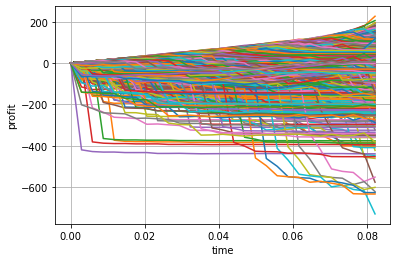

In [ ]:
plt.plot(timeGrid, profit, zorder=100)
plt.xlabel("time")
plt.ylabel("profit")
plt.grid(zorder=20)
plt.show()

In [ ]:
r = 0.04
sigma = 0.8
vol = 0.1

n = 30
m = 1560

T = 30/365
S = 3000
K = 3000


EuropeanCall(S, K, T, r, sigma)

278.3971034727758

In [ ]:
threshold = 0.01
TC = 0.003
nbSteps = 29
nbSim = 1568
vol = 0.1

timeGrid, trajectory, bank, strategy, deltaBS, profit = hedgingStrategy(S, K, T, r, sigma, "c", nbSteps, nbSim)
print(np.mean(profit[-1]))
print(np.std(profit[-1]))

-31.949413606689735
103.23138005139984


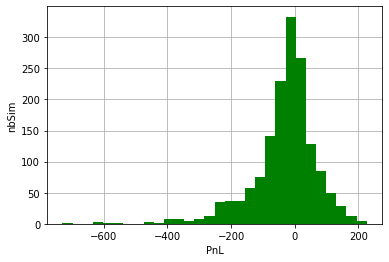

In [ ]:
plt.hist(profit[-1], 30, facecolor='g', zorder=20)
plt.xlabel("PnL")
plt.ylabel("nbSim")
plt.grid(zorder=20)
plt.show()

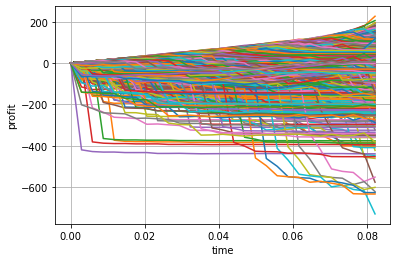

In [ ]:
plt.plot(timeGrid, profit, zorder=100)
plt.xlabel("time")
plt.ylabel("profit")
plt.grid(zorder=20)
plt.show()

In [ ]:
sigma = 0.2
timeGrid, trajectory, bank, strategy, deltaBS, profit = hedgingStrategy(S, K, T, r, sigma, "c", nbSteps, nbSim)
print(np.mean(profit[-1]))
print(np.std(profit[-1]))

-211.78624326929094
160.22561329449724


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


In [ ]:
sigma = 0.3
timeGrid, trajectory, bank, strategy, deltaBS, profit = hedgingStrategy(S, K, T, r, sigma, "c", nbSteps, nbSim)
print(np.mean(profit[-1]))
print(np.std(profit[-1]))

-181.854787722098
140.4361310569768


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


In [ ]:
sigma = 0.4
timeGrid, trajectory, bank, strategy, deltaBS, profit = hedgingStrategy(S, K, T, r, sigma, "c", nbSteps, nbSim)
print(np.mean(profit[-1]))
print(np.std(profit[-1]))

-152.3309525933077
125.35501148990056


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


In [ ]:
sigma = 0.5
timeGrid, trajectory, bank, strategy, deltaBS, profit = hedgingStrategy(S, K, T, r, sigma, "c", nbSteps, nbSim)
print(np.mean(profit[-1]))
print(np.std(profit[-1]))

-122.79647409928839
114.57110750536859


In [ ]:
sigma = 0.6
timeGrid, trajectory, bank, strategy, deltaBS, profit = hedgingStrategy(S, K, T, r, sigma, "c", nbSteps, nbSim)
print(np.mean(profit[-1]))
print(np.std(profit[-1]))

-92.9136134648578
107.74524078405253


In [ ]:
sigma = 0.7
timeGrid, trajectory, bank, strategy, deltaBS, profit = hedgingStrategy(S, K, T, r, sigma, "c", nbSteps, nbSim)
print(np.mean(profit[-1]))
print(np.std(profit[-1]))

-62.539517963251996
104.18399959020084


In [ ]:
sigma = 0.8
timeGrid, trajectory, bank, strategy, deltaBS, profit = hedgingStrategy(S, K, T, r, sigma, "c", nbSteps, nbSim)
print(np.mean(profit[-1]))
print(np.std(profit[-1]))

-31.949413606689735
103.23138005139984


In [ ]:
sigma = 0.9
timeGrid, trajectory, bank, strategy, deltaBS, profit = hedgingStrategy(S, K, T, r, sigma, "c", nbSteps, nbSim)
print(np.mean(profit[-1]))
print(np.std(profit[-1]))

-1.1502461691581585
104.32797493699732


In [ ]:
sigma = 1
timeGrid, trajectory, bank, strategy, deltaBS, profit = hedgingStrategy(S, K, T, r, sigma, "c", nbSteps, nbSim)
print(np.mean(profit[-1]))
print(np.std(profit[-1]))

29.95592355682429
106.75038694509433


In [ ]:
sigma = 1.1
timeGrid, trajectory, bank, strategy, deltaBS, profit = hedgingStrategy(S, K, T, r, sigma, "c", nbSteps, nbSim)
print(np.mean(profit[-1]))
print(np.std(profit[-1]))

61.374231278439495
109.97863169420535


In [ ]:
sigma = 0
timeGrid, trajectory, bank, strategy, deltaBS, profit = hedgingStrategy(S, K, T, r, sigma, "c", nbSteps, nbSim)
print(np.mean(profit[-1]))
print(np.std(profit[-1]))

-264.32930027641464
237.6078750677941


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
